In [4]:
# %pip install transformers
# %pip install accelerate==0.20.3
# %pip install accelerate
# %pip install torch --index-url https://download.pytorch.org/whl/cu118
# %pip install pandas

  Using cached pandas-2.0.3-cp310-cp310-win_amd64.whl (10.7 MB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Shafakat Arnob\Main\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import torch

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cu118
Is CUDA enabled? True


In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 2060


In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
ROOT_DIR = '../trac2-dataset/hin/'

df_org= pd.read_csv(ROOT_DIR + "trac2_hin_train.csv")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,ID,Text,Sub-task A,Sub-task B
408,C4.413,Londe chutiye h sb. Movie dekh k bhot londo ko...,OAG,NGEN
2547,C21.229,Pratik tuje koi movie pasand ati ki nahi...,CAG,NGEN
682,C45.229.1,Bade bade kele ke sath,NAG,NGEN
3159,C7.2391,Bhai liberals ki marne ke chakkar me tumne kit...,CAG,NGEN
2356,C38.167,I have one question???? Can I ask u ''''''soch...,CAG,GEN


In [5]:
labels = df_org['Sub-task B'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['NGEN', 'GEN']

In [6]:
for key, value in enumerate(labels):
    print(value)

NGEN
GEN


In [7]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [8]:
label2id

{'NGEN': 0, 'GEN': 1}

In [9]:
id2label

{0: 'NGEN', 1: 'GEN'}

In [10]:
df_org.head()

,ID,Text,Sub-task A,Sub-task B
3883,C59.1200,great show,NAG,NGEN
2439,C7.2451.3,There just problem with the movie and where I ...,NAG,NGEN
1786,C33.644.4,Rohit barman nice,NAG,NGEN
2329,C4.1321,Totally agreed with your practicality but ther...,NAG,NGEN
2567,C10.576,From today onward she will be called kungfu bitc?,NAG,NGEN


In [11]:
df_org["labels"]=df_org['Sub-task B'].map(lambda x: label2id[x.strip()])

In [12]:
df_org.head()

,ID,Text,Sub-task A,Sub-task B,labels
3883,C59.1200,great show,NAG,NGEN,0
2439,C7.2451.3,There just problem with the movie and where I ...,NAG,NGEN,0
1786,C33.644.4,Rohit barman nice,NAG,NGEN,0
2329,C4.1321,Totally agreed with your practicality but ther...,NAG,NGEN,0
2567,C10.576,From today onward she will be called kungfu bitc?,NAG,NGEN,0


<AxesSubplot:ylabel='Sub-task B'>

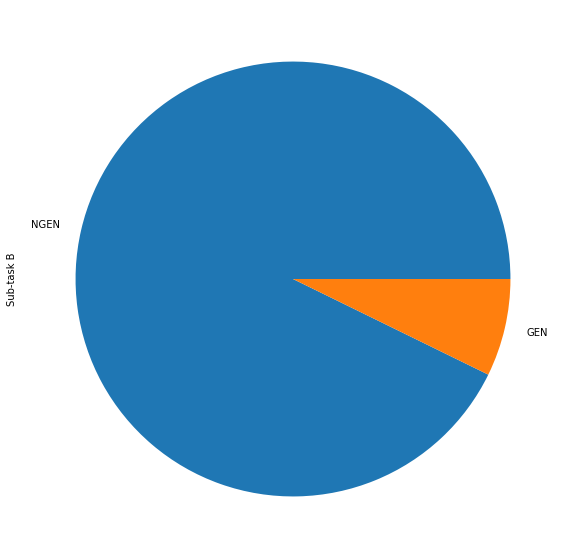

In [13]:
df_org['Sub-task B'].value_counts().plot(kind='pie', figsize=(10,10))

In [14]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
# Splitting df_org

SIZE= df_org.shape[0]

train_texts= list(df_org.Text[:SIZE//2])

val_texts=   list(df_org.Text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.Text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [17]:
len(train_texts)

2131

In [18]:
len(train_texts), len(val_texts), len(test_texts)

(2131, 1066, 1066)

In [19]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [20]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [21]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [22]:
# Training with Trainer Class
from transformers import TrainingArguments, Trainer

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [25]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./hin-monolingual-bert-results',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./hin-monolingual-bert-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [26]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
